<a href="https://colab.research.google.com/github/umesh2908/Machine-learning-projects/blob/master/Water_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset=pd.read_clipboard()
dataset

PyperclipException: ignored

In [ ]:
df=pd.read_csv(r'/content/water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


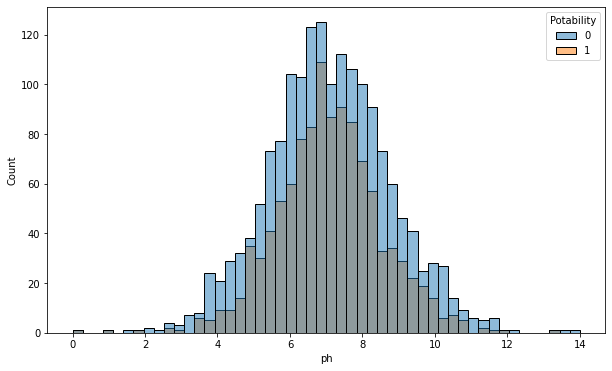

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x='ph',hue='Potability',data=df,bins=50)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


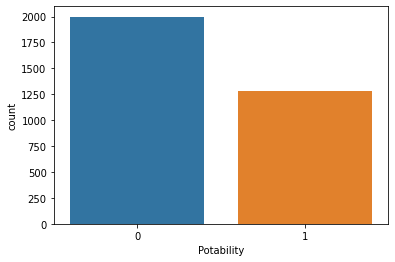

In [ ]:
sns.countplot('Potability',data=df)

In [ ]:
is_clean = df.apply(lambda x: x.isna().sum()<1,axis=1)
is_clean


0       False
1       False
2       False
3        True
4        True
        ...  
3271     True
3272    False
3273    False
3274    False
3275    False
Length: 3276, dtype: bool

In [ ]:
n_clean   = 600
clean_idx = df.index[is_clean][:n_clean]

In [ ]:
# 4. get clean validation data
Y_valid = df.iloc[clean_idx,-1:].copy().reset_index(drop=True)
X_valid = df.iloc[clean_idx,:-1].copy().reset_index(drop=True)

In [ ]:
# 5. get training data
mask = [x for x in df.index if x not in clean_idx]
Y    = df.iloc[mask,-1:].copy().reset_index(drop=True)
X    = df.iloc[mask,:-1].copy().reset_index(drop=True)

In [ ]:
X_valid.isnull().sum(),X.isnull().sum()

(ph                 0
 Hardness           0
 Solids             0
 Chloramines        0
 Sulfate            0
 Conductivity       0
 Organic_carbon     0
 Trihalomethanes    0
 Turbidity          0
 dtype: int64, ph                 491
 Hardness             0
 Solids               0
 Chloramines          0
 Sulfate            781
 Conductivity         0
 Organic_carbon       0
 Trihalomethanes    162
 Turbidity            0
 dtype: int64)

In [ ]:
# basic statistics - median
X_fill = X.copy()

# loop through the columns and replace missings with median
for col in X_fill.columns:
    X_fill[col] = X_fill[col].fillna(X_fill[col].median())

In [ ]:
X_fill.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

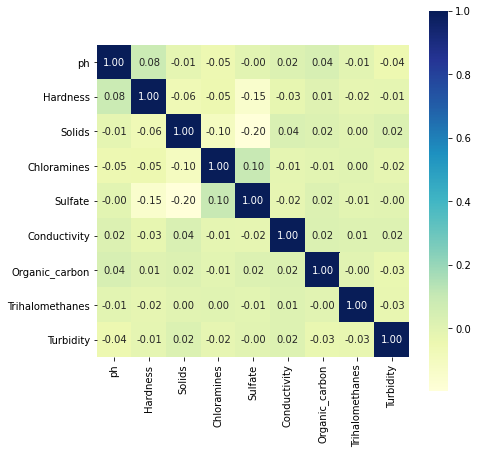

In [ ]:
Corrmat = X_fill.corr()
plt.subplots(figsize=(7,7))
sns.heatmap(Corrmat, cmap="YlGnBu", square = True, annot=True, fmt='.2f')
plt.show()

In [ ]:
list(X_fill.columns)

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity']

density distribution of different features by Potability



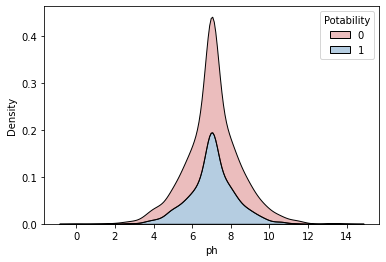

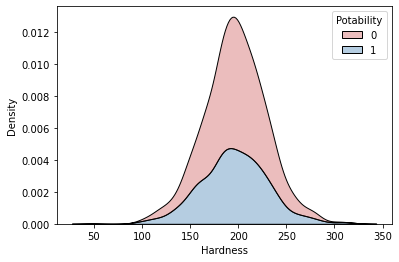

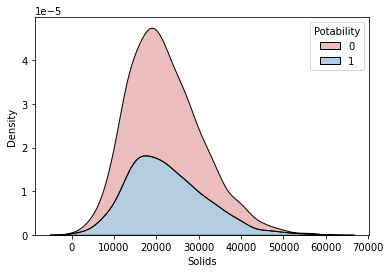

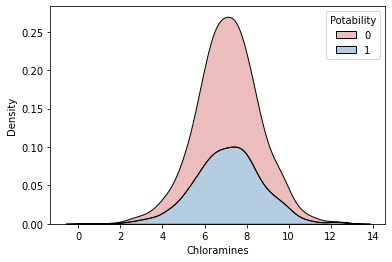

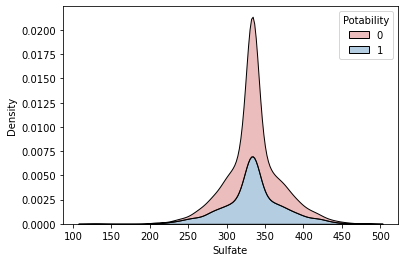

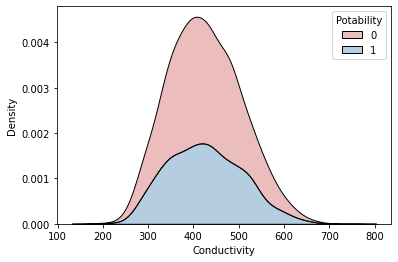

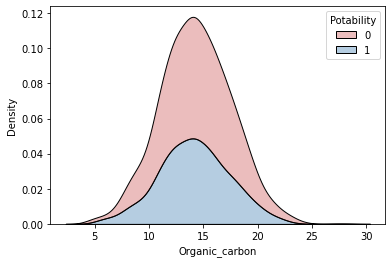

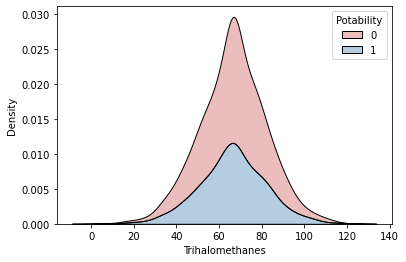

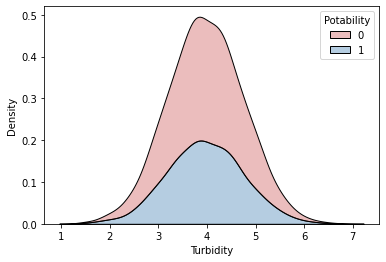

In [ ]:
print('density distribution of different features by Potability\n')
features = list(X_fill.columns)
for cols in features:
    sns.kdeplot(X_fill[cols], fill=True, alpha=0.4, hue = Y.Potability,palette=('indianred', 'steelblue'), multiple='stack')
    plt.show()

In [ ]:
print('Correlation of Potability with feature variables:')

Corr = list()
for cols in features:
    Corr.append(X_fill[cols].corr(Y['Potability']))

corrDf = pd.DataFrame({'Features' : features, 'Corr' : Corr})
corrDf['Corr'] = corrDf['Corr'].abs()
corrDf.sort_values(by='Corr', ascending = True).reset_index(drop=True)

Correlation of Potability with feature variables:


,Features,Corr
0,Conductivity,0.000940
1,Chloramines,0.003378
2,Turbidity,0.005664
3,Trihalomethanes,0.007356
4,Sulfate,0.008132
5,Hardness,0.017680
6,ph,0.018224
7,Organic_carbon,0.035540
8,Solids,0.037858


Text(0, 0.5, 'Corr')

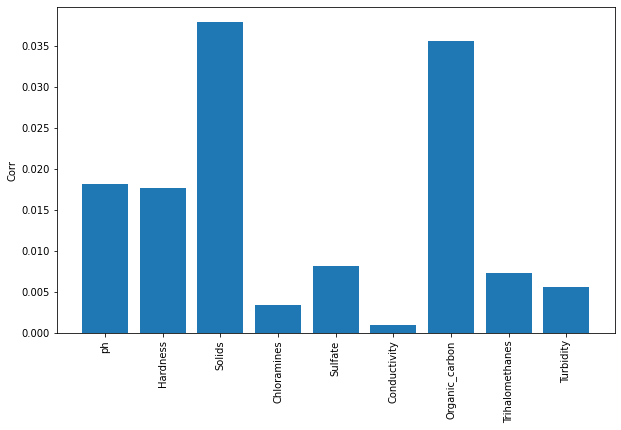

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(corrDf['Features'], corrDf['Corr'], width=0.8, bottom=None, align='center')
plt.xticks(rotation=90) 
plt.ylabel('Corr')

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, accuracy_score
from sklearn.model_selection import (GridSearchCV, KFold, train_test_split, cross_val_score)

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
pip install catboost

     |████████████████████████████████| 69.2 MB 4.8 kB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
model = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB(), RandomForestClassifier(), ExtraTreesClassifier(),
        svm.LinearSVC(), XGBClassifier(), CatBoostClassifier()]
trainAccuracy = list()
testAccuracy = list()
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

for mdl in model:
    trainResult = cross_val_score(mdl, X_fill, Y, scoring='accuracy', cv=kfold)
    trainAccuracy.append(trainResult.mean())
    mdl.fit(X_fill, Y)
    y_pred = mdl.predict(X_valid)
    testResult = metrics.accuracy_score(Y_valid, y_pred)
    testAccuracy.append(testResult)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6850131	total: 19.3ms	remaining: 3.83s
5:	learn: 0.6834295	total: 23.1ms	remaining: 3.83s
6:	learn: 0.6818190	total: 26.7ms	remaining: 3.78s
7:	learn: 0.6807048	total: 34.4ms	remaining: 4.27s
8:	learn: 0.6789135	total: 40.6ms	remaining: 4.47s
9:	learn: 0.6774381	total: 44.2ms	remaining: 4.38s
10:	learn: 0.6756623	total: 48.1ms	remaining: 4.32s
11:	learn: 0.6740339	total: 51.6ms	remaining: 4.25s
12:	learn: 0.6728426	total: 55.2ms	remaining: 4.19s
13:	learn: 0.6714420	total: 58.8ms	remaining: 4.14s
14:	learn: 0.6701442	total: 62.5ms	remaining: 4.1s
15:	learn: 0.6685635	total: 66.2ms	remaining: 4.07s
16:	learn: 0.6669784	total: 70ms	remaining: 4.05s
17:	learn: 0.6652147	total: 73.6ms	remaining: 4.02s
18:	learn: 0.6637122	total: 77.2ms	remaining: 3.99s
19:	learn: 0.6626949	total: 80.9ms	remaining: 3.96s
20:	learn: 0.6613045	total: 84.5ms	remaining: 3.94s
21:	learn: 0.6604265	total: 88.1ms	remaining: 3.92s
22:	learn: 0.6597483	t

In [ ]:
print('The comparision\n')
modelScore = pd.DataFrame({'Model' : model, 'Train_Accuracy' : trainAccuracy, 'Test_Accuracy' : testAccuracy})
modelScore

The comparision



,Model,Train_Accuracy,Test_Accuracy
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.597170,0.665000
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.571056,0.576667
2,"GaussianNB(priors=None, var_smoothing=1e-09)",0.598681,0.676667
3,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.657340,0.656667
4,"(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...",0.655473,0.648333
5,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.516430,0.335000
6,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.639039,0.680000
7,<catboost.core.CatBoostClassifier object at 0x...,0.663327,0.660000


Model with Data Standardization 

In [ ]:
print('Balancing the data by SMOTE - Oversampling of Minority level\n')
smt = SMOTE()
counter = Counter(Y)
print('Before SMOTE', counter)
X_train, y_train = smt.fit_resample(X_fill, Y)
counter = Counter(y_train)
print('\nAfter SMOTE', counter)

Balancing the data by SMOTE - Oversampling of Minority level

Before SMOTE Counter({'Potability': 1})

After SMOTE Counter({0: 1599, 1: 1599})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
ssc = StandardScaler()

X_train = ssc.fit_transform(X_train)
X_test = ssc.transform(X_valid)

In [ ]:
model = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB(), RandomForestClassifier(), ExtraTreesClassifier(),
        svm.LinearSVC(), XGBClassifier(), CatBoostClassifier()]
trainAccuracy = list()
testAccuracy = list()
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

for mdl in model:
    trainResult = cross_val_score(mdl, X_train, y_train, scoring='accuracy', cv=kfold)
    trainAccuracy.append(trainResult.mean())
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    testResult = metrics.accuracy_score(Y_valid, y_pred)
    testAccuracy.append(testResult)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6855360	total: 27.2ms	remaining: 5.41s
5:	learn: 0.6841801	total: 33.3ms	remaining: 5.52s
6:	learn: 0.6827365	total: 36.9ms	remaining: 5.23s
7:	learn: 0.6821399	total: 40.6ms	remaining: 5.04s
8:	learn: 0.6811990	total: 44.3ms	remaining: 4.88s
9:	learn: 0.6796876	total: 48ms	remaining: 4.75s
10:	learn: 0.6784515	total: 51.7ms	remaining: 4.64s
11:	learn: 0.6767720	total: 55.5ms	remaining: 4.57s
12:	learn: 0.6757240	total: 59.6ms	remaining: 4.52s
13:	learn: 0.6744554	total: 63.6ms	remaining: 4.48s
14:	learn: 0.6733903	total: 67.7ms	remaining: 4.45s
15:	learn: 0.6720832	total: 71.7ms	remaining: 4.41s
16:	learn: 0.6706040	total: 75.6ms	remaining: 4.37s
17:	learn: 0.6692471	total: 79.5ms	remaining: 4.34s
18:	learn: 0.6676790	total: 83.4ms	remaining: 4.31s
19:	learn: 0.6666624	total: 87.2ms	remaining: 4.27s
20:	learn: 0.6654988	total: 91ms	remaining: 4.24s
21:	learn: 0.6645963	total: 94.8ms	remaining: 4.21s
22:	learn: 0.6636725	to

In [ ]:
print('The comparision\n')
modelScore = pd.DataFrame({'Model' : model, 'Train_Accuracy' : trainAccuracy, 'Test_Accuracy' : testAccuracy})
modelScore

The comparision



,Model,Train_Accuracy,Test_Accuracy
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.503449,0.515000
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.620381,0.526667
2,"GaussianNB(priors=None, var_smoothing=1e-09)",0.559098,0.528333
3,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.709815,0.590000
4,"(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...",0.723563,0.590000
5,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.504074,0.515000
6,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.662915,0.521667
7,<catboost.core.CatBoostClassifier object at 0x...,0.707944,0.548333
